# Feature extraction from sentences

- First, we'll keep it short and simple using **pandas and csv** files to share the data.
- In case the dataset will grow much, we will switch to **sqlite or even postgres** (with possibility for online hosted version for everybody to access easily)

In this jupyter notebook:

1. generate features per dataset source
2. generate statistics and/or union necessary datasets

In [1]:
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib.pyplot as plt
import random

# linguistic
import string
import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize

#setup
pd.set_option('display.max_columns', 500)

FOLDER_NOVELS = os.path.join("..", "datasets", "not_scientific_novels")
FOLDER_MEDIUM = os.path.join("..", "datasets", "almost_scientific_medium")
FOLDER_REPORTS = os.path.join("..", "datasets", "almost_scientific_reports")
FOLDER_ARXIV = os.path.join("..", "datasets", "scientific_arxiv")

# might need:
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('universal_tagset')

ModuleNotFoundError: No module named 'seaborn'

# Setup

In [2]:
CHOICE = 0
choices = ['medium_vs_arxiv', "acl_good_vs_bad"]
print(f"You chose {choices[CHOICE]}")

if CHOICE == 0:
    
    sent_medium = pickle.load(open(os.path.join(FOLDER_MEDIUM, "sentences.pickle"), "rb"))
    sent_arxiv = pickle.load(open(os.path.join(FOLDER_ARXIV, "sentences.pickle"), "rb"))

    # selecting sentences
    random.shuffle(sent_medium)
    random.shuffle(sent_arxiv)
    sent_medium = sent_medium[:2000]
    sent_arxiv = sent_arxiv[:2000]

    df_medium = pd.DataFrame(data=sent_medium, columns=["sentence"])
    df_medium['scientific'] = 0
    df_arxiv = pd.DataFrame(data=sent_arxiv, columns=["sentence"])
    df_arxiv['scientific'] = 1

    df = pd.concat([df_medium, df_arxiv], ignore_index=True)
    print(f"df: {df.shape}")
    
if CHOICE == 1:
    
    df = pd.read_csv(os.path.join('datasets', 'almost_scientific_papers', 'processed', 'acl', 'papers_with_scores_cleaned.csv'))
    df["sentences"] = df["text_clean"].apply(lambda x: sent_tokenize(x))
    df["num"] = df['sentences'].apply(lambda x: len(x))
    
    sent_acl_good = []
    for sentence_set in df[df.clarity_weighted > 4.5].sentences:
        sent_acl_good.extend(sentence_set)
    sent_acl_bad = []
    for sentence_set in df[df.clarity_weighted < 3.5].sentences:
        sent_acl_bad.extend(sentence_set)

    # selecting sentences
    random.shuffle(sent_acl_good)
    random.shuffle(sent_acl_bad)
    sent_acl_good = sent_acl_good[:300]
    sent_acl_bad = sent_acl_bad[:300]

    df_acl_bad = pd.DataFrame(data=sent_acl_bad, columns=["sentence"])
    df_acl_bad['scientific'] = 0
    df_acl_good = pd.DataFrame(data=sent_acl_good, columns=["sentence"])
    df_acl_good['scientific'] = 1

    df = pd.concat([df_acl_bad, df_acl_good], ignore_index=True)
    
    print(f"df: {df.shape}")

You chose medium_vs_arxiv
df: (4000, 2)


# Features

## Number of characters, words, punctuation, by POS tag

In [3]:
# Length of sentence in characters, words
df.head()

,sentence,scientific
0,Data Engineers are familiar with SQL and Pytho...,0
1,But this cannot mean that users are really tas...,0
2,where dθ = (θ_new -θ_old).,0
3,Each of the Fortune 100 corporations in the ae...,0
4,Lets load it:,0


In [4]:
# for speed: fill lists first, later add to pandas dataframe
num_words = []
num_punctuation = []
num_by_POS_tag = []
pos_tags = set()

for idx,sent in enumerate(df['sentence']):
    if idx > 0 and idx % 100 == 0:
        print(f"progress: {idx} / {len(df)}")
    tokens = word_tokenize(sent)
    
    # number of words
    num_words.append(len([word for word in tokens if not word in string.punctuation]))
    
    # number of punctuation characters
    num_punctuation.append(len([word for word in tokens if word in string.punctuation]))
    
    # number by POS tag
    # todo: implement
    tagged = nltk.pos_tag(tokens)
    #simplified = [(word, nltk.tag.map_tag('en-ptb', 'universal', tag)) for word, tag in tagged]
    counts = dict()
    for (i,j) in tagged:
        counts[j] = counts.get(j, 0) + 1
    num_by_POS_tag.append(counts)
    pos_tags.update(counts.keys())
print("done")

progress: 100 / 4000
progress: 200 / 4000
progress: 300 / 4000
progress: 400 / 4000
progress: 500 / 4000
progress: 600 / 4000
progress: 700 / 4000
progress: 800 / 4000
progress: 900 / 4000
progress: 1000 / 4000
progress: 1100 / 4000
progress: 1200 / 4000
progress: 1300 / 4000
progress: 1400 / 4000
progress: 1500 / 4000
progress: 1600 / 4000
progress: 1700 / 4000
progress: 1800 / 4000
progress: 1900 / 4000
progress: 2000 / 4000
progress: 2100 / 4000
progress: 2200 / 4000
progress: 2300 / 4000
progress: 2400 / 4000
progress: 2500 / 4000
progress: 2600 / 4000
progress: 2700 / 4000
progress: 2800 / 4000
progress: 2900 / 4000
progress: 3000 / 4000
progress: 3100 / 4000
progress: 3200 / 4000
progress: 3300 / 4000
progress: 3400 / 4000
progress: 3500 / 4000
progress: 3600 / 4000
progress: 3700 / 4000
progress: 3800 / 4000
progress: 3900 / 4000
done


In [5]:
# add to pandas dataframe

# num chars
df['num_chars'] = [len(s) for s in df['sentence']]

# num words
df['num_words'] = num_words

# num punctuation
df['num_punctuation'] = num_punctuation

# num POS tags
def update_row_with_dict(df,d,idx):
    df.loc[idx,d.keys()] = d.values()
    
df[list(pos_tags)] = 0
for idx in df.index:
    update_row_with_dict(df,num_by_POS_tag[idx],idx)

In [6]:
df.head()

,sentence,scientific,num_chars,num_words,num_punctuation,VBP,PRP$,POS,EX,RBS,IN,SYM,MD,#,:,WRB,.,WP,NNP,UH,RBR,RB,FW,RP,$,VBZ,JJ,NN,'',WDT,VBG,NNS,),WP$,VB,CD,DT,JJS,",",PRP,JJR,VBN,(,VBD,CC,TO,LS,PDT,NNPS
0,Data Engineers are familiar with SQL and Pytho...,0,83,16,2,2,0,0,0,0,2,0,0,0,0,0,1,0,5,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,3,0,0,0,0
1,But this cannot mean that users are really tas...,0,116,22,1,1,0,0,0,0,3,0,2,0,0,0,1,0,0,0,0,2,0,0,0,0,1,2,0,1,1,1,0,0,2,0,4,0,0,0,0,1,0,0,1,0,0,0,0
2,where dθ = (θ_new -θ_old).,0,26,4,4,0,0,0,0,0,0,0,0,0,0,1,1,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Each of the Fortune 100 corporations in the ae...,0,147,25,2,0,0,0,0,0,4,0,0,0,0,0,1,0,1,0,0,3,0,0,0,0,0,4,0,0,0,3,0,0,1,1,5,0,1,0,0,0,0,1,1,0,0,1,0
4,Lets load it:,0,13,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [7]:
# List of possible POS tags by nltk
#nltk.help.upenn_tagset()

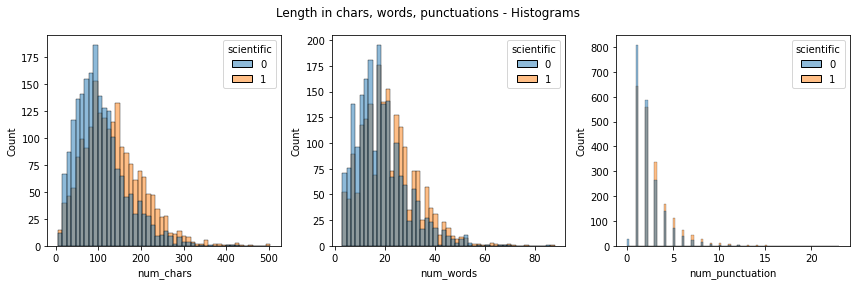

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('Length in chars, words, punctuations - Histograms')


sns.histplot(x=df.num_chars, hue=df.scientific, ax=axs[0])
sns.histplot(x=df.num_words, hue=df.scientific, ax=axs[1])
sns.histplot(x=df.num_punctuation, hue=df.scientific, ax=axs[2])

fig.tight_layout()

Kernel Density Plots instead of histrograms:

- Smoother curves -> concentrated values better visible
- not depending upon bins in histrogram

details:
A Density Plot visualises the distribution of data over a continuous interval or time period. This chart is a variation of a Histogram that uses kernel smoothing to plot values, allowing for smoother distributions by smoothing out the noise. The peaks of a Density Plot help display where values are concentrated over the interval.

An advantage Density Plots have over Histograms is that they're better at determining the distribution shape because they're not affected by the number of bins used (each bar used in a typical histogram). A Histogram comprising of only 4 bins wouldn't produce a distinguishable enough shape of distribution as a 20-bin Histogram would. However, with Density Plots, this isn't an issue.
(source: [https://datavizcatalogue.com/methods/density_plot.html](https://datavizcatalogue.com/methods/density_plot.html))

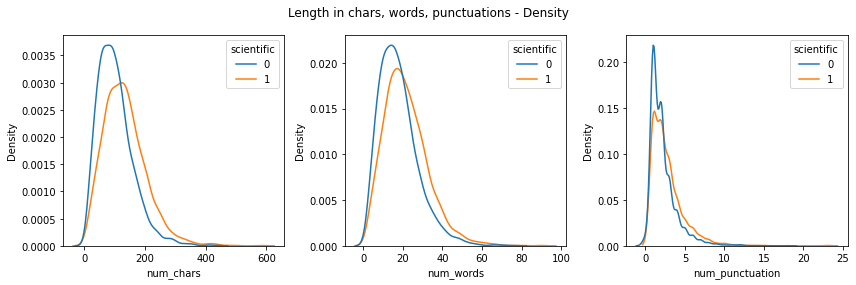

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('Length in chars, words, punctuations - Density')


sns.kdeplot(x=df.num_chars, hue=df.scientific, ax=axs[0])
sns.kdeplot(x=df.num_words, hue=df.scientific, ax=axs[1])
sns.kdeplot(x=df.num_punctuation, hue=df.scientific, ax=axs[2])

fig.tight_layout()

/Users/arthur/.pyenv/versions/default/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/arthur/.pyenv/versions/default/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/arthur/.pyenv/versions/default/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/arthur/.pyenv/versions/default/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


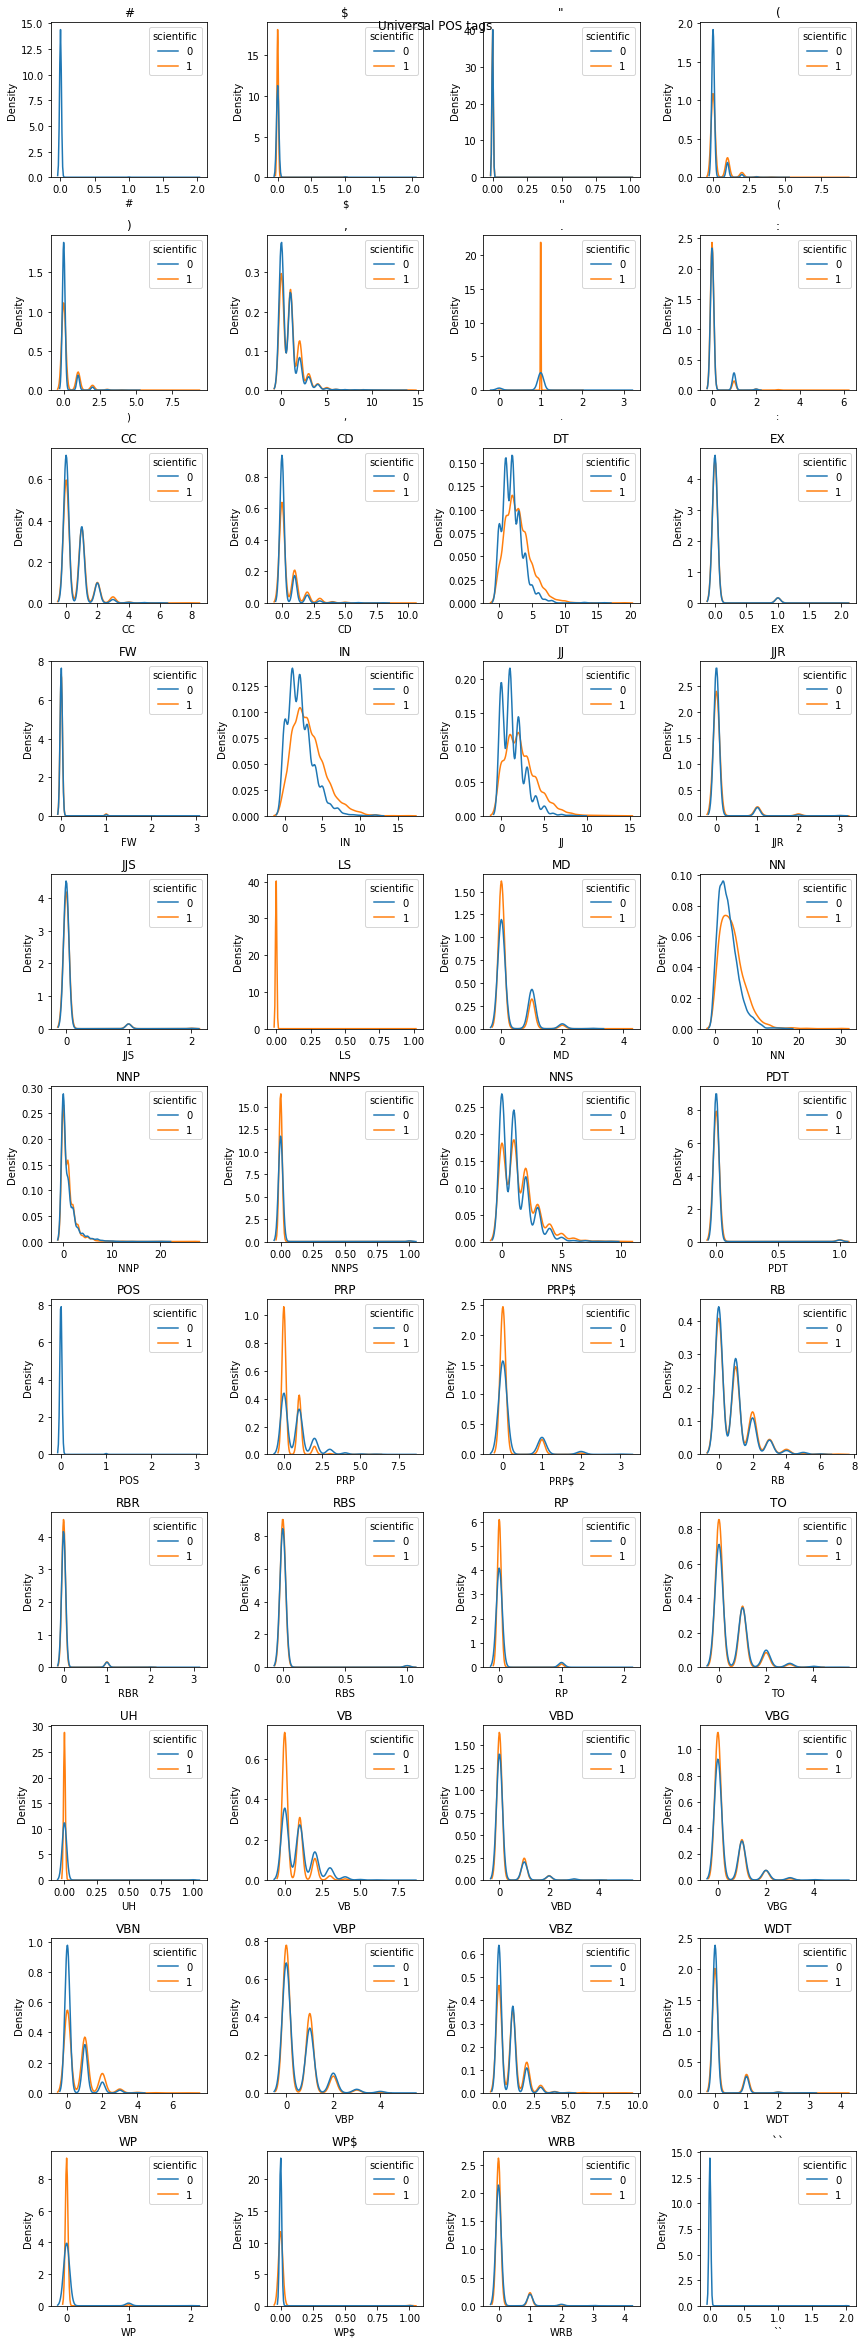

In [10]:
import math
ntags = len(pos_tags)

fig, axs = plt.subplots(math.ceil(ntags/4), 4, figsize=(12,3*math.ceil(ntags/4)))
fig.suptitle('Universal POS tags')
axs = axs.ravel()

for i,tag in enumerate(sorted(list(pos_tags))):
    sns.kdeplot(
        data=df[list(pos_tags) + ["scientific"]],
        x=tag,
        hue="scientific",
        ax=axs[i])
    axs[i].set_title(tag)

fig.tight_layout()

## Tense of sentence

- using pos tagger, parser.
- put main verb on top of parse tree and check its tense

## active vs. passive

In [9]:
from nltk.parse import CoreNLPParser
from nltk.parse.corenlp import CoreNLPDependencyParser

# Lexical Parser
parser = CoreNLPParser(url='http://localhost:9000')
# POS tagger
pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')
# NER Tagger
ner_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='ner')

# Neural Dependency Parser
dep_parser = CoreNLPDependencyParser(url='http://localhost:9000')

def is_sentence_passive(dep_parser, sentence):
    """
    Identify whether a sentence is active or passive.
    returns: Boolean
    """
    parses = dep_parser.parse(sentence.split())
    for parse in parses:
        for governor, dep, dependent in parse.triples():
            if dep.endswith(":pass"):
                return True
    return False

In [10]:
from tqdm.notebook import tqdm
tqdm.pandas()

df['is_passive'] = df['sentence'].progress_apply(lambda x: int(is_sentence_passive(dep_parser, x)))

  0%|          | 0/4000 [00:00<?, ?it/s]

<AxesSubplot:xlabel='is_passive', ylabel='Count'>

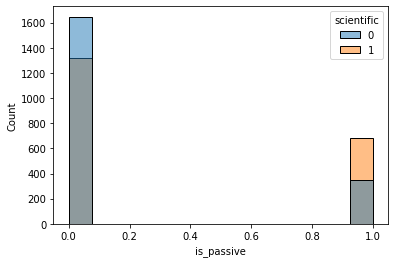

In [11]:
sns.histplot(x=df.is_passive, hue=df.scientific)

## sentence structure

- sci: rather longer and more subordinate sentences (if, because, ...)

## keyword list // blocklist for almost scientific vocabs

- sci: hence, if, furthermore...
- non-sci: I, we ...

## further ideas

blocklist

- Todeswörter: man kann sehen, .... 
- tf-idf on good ACL vs. medium

Satzbau

- parsetrees (spaCy)
- HMM -> given sequence (forward algorithm HMMs) -> how probable is the structure for scientific sentences vs. almost-scientific

synonyms

- word2vec (encoder) -> close words to non-scientific words

default rules

- first -> second -> ... finally
- on the one hand -> on the other hand (has to follow)


more non-style:

- Rechtschreibung (dictionary, Levenstein)
- Grammatik


man könnte noch auf "consistent use" von Schreibweisen und Vokabeln achten. Z. B. pre-processing vs. preprocessing (beides richtig) oder data points vs. datapoints. Sollte evtl. einfach mit einer art similarity-score oder so zu lösen sein.

Und die nutzung von konsistenten Zeitformen ist auch noch wichtig!

# SVM Classifier

Why SVM?

- Is more effective in high dimensional spaces.
- "Kernal Trick" is helpful here due to the high dimensional space.
- Binary classification problem.
- Also effective if number of dimensions is larger than the number of samples -> might happen due to tf-idf
- support vectores -> memory efficient for large documents.

## Model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

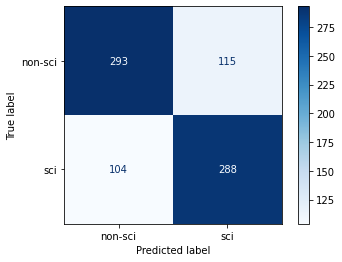

In [13]:
exclude_from_training = ["sentence", "scientific", "num_chars"]
cols_for_training = ['DET', '.', 'ADP', 'ADV', 'VERB', 'PRT', 'CONJ', 'ADJ', 'NUM', 'NOUN', 'X', 'PRON', 'is_passive']

# normalize pos tags and num_punctuation for SVM model
#df[list(pos_tags) + ["num_punctuation"]] = df[list(pos_tags) + ["num_punctuation"]].div(df.num_words, axis=0)

X = df.drop(exclude_from_training, axis=1)
y = df['scientific']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

clf_svm = SVC(kernel='rbf')
clf_svm.fit(X_train, y_train)


y_pred = clf_svm.predict(X_test)
plot_confusion_matrix(clf_svm,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

In [14]:
print(classification_report(y_test,y_pred, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.74      0.72      0.73       408
         sci       0.71      0.73      0.72       392

    accuracy                           0.73       800
   macro avg       0.73      0.73      0.73       800
weighted avg       0.73      0.73      0.73       800



## Hyperparameter tuning

In [15]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=1)

In [16]:
df.head()

,sentence,scientific,num_chars,num_words,num_punctuation,VBP,PRP$,POS,EX,RBS,IN,SYM,MD,#,:,WRB,.,WP,NNP,UH,RBR,RB,FW,RP,$,VBZ,JJ,NN,'',WDT,VBG,NNS,),WP$,VB,CD,DT,JJS,",",PRP,JJR,VBN,(,VBD,CC,TO,LS,PDT,NNPS,is_passive
0,Data Engineers are familiar with SQL and Pytho...,0,83,16,2,2,0,0,0,0,2,0,0,0,0,0,1,0,5,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,3,0,0,0,0,0
1,But this cannot mean that users are really tas...,0,116,22,1,1,0,0,0,0,3,0,2,0,0,0,1,0,0,0,0,2,0,0,0,0,1,2,0,1,1,1,0,0,2,0,4,0,0,0,0,1,0,0,1,0,0,0,0,1
2,where dθ = (θ_new -θ_old).,0,26,4,4,0,0,0,0,0,0,0,0,0,0,1,1,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Each of the Fortune 100 corporations in the ae...,0,147,25,2,0,0,0,0,0,4,0,0,0,0,0,1,0,1,0,0,3,0,0,0,0,0,4,0,0,0,3,0,0,1,1,5,0,1,0,0,0,0,1,1,0,0,1,0,0
4,Lets load it:,0,13,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.001)


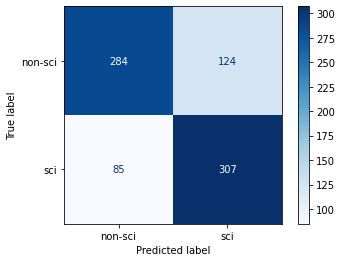

In [17]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
  
plot_confusion_matrix(grid,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

In [18]:
# print classification report
print(classification_report(y_test, grid_predictions, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.77      0.70      0.73       408
         sci       0.71      0.78      0.75       392

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800



In [19]:
# vs before tuning
print(classification_report(y_test,y_pred, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.74      0.72      0.73       408
         sci       0.71      0.73      0.72       392

    accuracy                           0.73       800
   macro avg       0.73      0.73      0.73       800
weighted avg       0.73      0.73      0.73       800



## Results

In [7]:
# https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
import shap

# The SHAP values
X_sample = shap.sample(X, nsamples=50, random_state=0)

svm_explainer = shap.KernelExplainer(grid.predict,X_sample)
svm_shap_values = svm_explainer.shap_values(X_sample)

NameError: name 'X' is not defined

In [8]:
import pickle

read_only = True

if read_only:
    backup_dir = os.path.join("backup", "v1_50shapSamples")
    with open(os.path.join(backup_dir, "svm_shap_values.pkl"), 'rb') as f:
        svm_shap_values = pickle.load(f)
    with open(os.path.join(backup_dir, "x_sample.pkl"), 'rb') as f:
        X_sample = pickle.load(f)

else:

    backup_dir = os.path.join("backup", "v2")
    os.makedirs(backup_dir, exist_ok=True)
    with open(os.path.join(backup_dir, "svm_shap_values.pkl"), "wb") as f:
        pickle.dump(svm_shap_values, f)
    with open(os.path.join(backup_dir, "x_sample.pkl"), "wb") as f:
        pickle.dump(X_sample, f)

In [40]:
# export summary plot
shap.summary_plot(svm_shap_values, X_sample, show=False)
plt.title("SHAP summary plot")
plt.tight_layout()
plt.savefig(os.path.join("03_text_features_plots","shap_summary_plot.png"), facecolor='white', dpi=300)
plt.close()

In [46]:
# export dependence plots
feature_list = ["VB", "IN", "JJ", "num_words", ".", "PRP", "(", "num_punctuation", "is_passive"]
for feature in feature_list:
    print(feature)
    shap.dependence_plot(feature, svm_shap_values, X_sample, show=False)
    plt.title(f"SHAP dependence plot for {feature}")
    plt.tight_layout()
    plt.savefig(os.path.join("03_text_features_plots",f"shap_dep_plot_{feature}.png"), facecolor='white', dpi=300)
    plt.close()

VB
IN
JJ
num_words
.
PRP
(
num_punctuation
is_passive


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


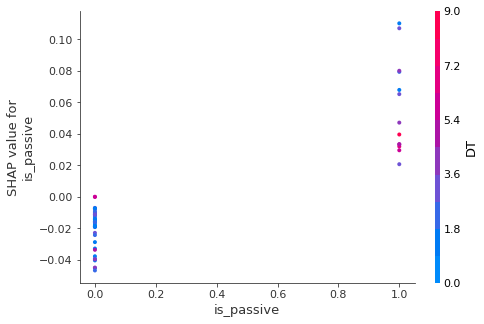

In [10]:
# http://www.nltk.org/book/ch05.html
# rather linear positive trend: The more ADP, the rather it is scientific:
# ADP	adposition	on, of, at, with, by, into, under
shap.dependence_plot("is_passive", svm_shap_values, X_sample)

In [24]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

# Features (corpus based)

## Difference in vocabulary

- tf-idf
- performed on whole corpus, not sencente based

In [ ]:
# next: https://medium.com/@eiki1212/feature-extraction-in-natural-language-processing-with-python-59c7cdcaf064